# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Fine tunning de CamemBERT pour classification infox


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from tqdm.notebook import tqdm,trange
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

## Labels ou textes Nuls

In [5]:
df_label['text'].isna().sum()

0

In [6]:
df_label['infox'].isna().sum()

4

In [7]:
df_label = df_label[df_label['infox'].notna()]

In [8]:
df_label.reset_index(inplace=True)

## Données dupliquées

In [9]:
df_label.duplicated(subset='text').sum()

0

In [10]:
df_label.duplicated(subset='url').sum()

0

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

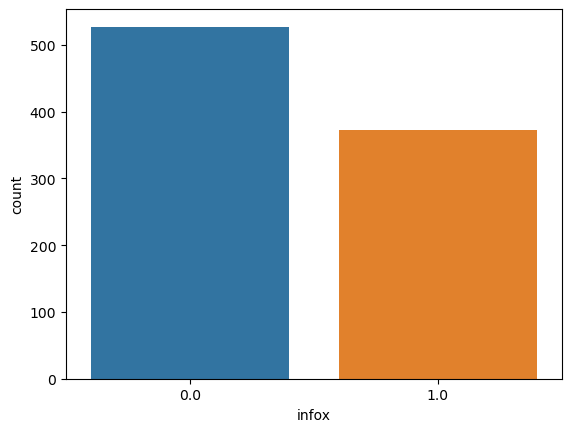

In [11]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [12]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])[['text','infox']]

df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


# Experience
---

In [13]:
# Importing specific libraries for data prerpcessing, model archtecture choice, training and evaluation
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import AdamW

In [14]:
# Defining constants
epochs = 2
MAX_LEN = 512
batch_size = 16
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

## Spliting Training and validation data

In [15]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

# Creates list of texts and labels
text = df_ml['text'].to_list()
labels = df_ml['infox'].astype(int).to_list()

#user tokenizer to convert sentences into tokenizer
input_ids = [
    tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN,truncation=True)
    for sent in text
]

# Pad our input tokens
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN,
                          dtype="long",
                          truncating="post",
                          padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i > 0) for i in seq]
    attention_masks.append(seq_mask)

In [16]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    input_ids, labels, attention_masks, random_state=42, test_size=0.2)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [17]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=batch_size)


In [18]:
# CamemBERT model

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

# Defining the parameters and metrics to optimize

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{
    'params':
    [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.01
}, {
    'params':
    [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate':
    0.0
}]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.weig

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
# Training and evaluating our model
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for e in range(epochs):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        print(f'Epoch : {e} Step: {step}')
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
    

Epoch : 0 Step: 0
Epoch : 0 Step: 1
Epoch : 0 Step: 2
Epoch : 0 Step: 3
Epoch : 0 Step: 4
Epoch : 0 Step: 5
Epoch : 0 Step: 6
Epoch : 0 Step: 7
Epoch : 0 Step: 8
Epoch : 0 Step: 9
Epoch : 0 Step: 10
Epoch : 0 Step: 11
Epoch : 0 Step: 12
Epoch : 0 Step: 13
Epoch : 0 Step: 14
Epoch : 0 Step: 15
Epoch : 0 Step: 16
Epoch : 0 Step: 17
Epoch : 0 Step: 18
Epoch : 0 Step: 19
Epoch : 0 Step: 20
Epoch : 0 Step: 21
Epoch : 0 Step: 22
Epoch : 0 Step: 23
Epoch : 0 Step: 24
Epoch : 0 Step: 25
Epoch : 0 Step: 26
Epoch : 0 Step: 27
Epoch : 0 Step: 28
Epoch : 0 Step: 29
Epoch : 0 Step: 30
Epoch : 0 Step: 31
Epoch : 0 Step: 32
Epoch : 0 Step: 33
Epoch : 0 Step: 34
Epoch : 0 Step: 35
Epoch : 0 Step: 36
Epoch : 0 Step: 37
Train loss: 0.6659990172637137
Validation Accuracy: 0.75625
Epoch : 1 Step: 0
Epoch : 1 Step: 1
Epoch : 1 Step: 2
Epoch : 1 Step: 3
Epoch : 1 Step: 4
Epoch : 1 Step: 5
Epoch : 1 Step: 6
Epoch : 1 Step: 7
Epoch : 1 Step: 8
Epoch : 1 Step: 9
Epoch : 1 Step: 10
Epoch : 1 Step: 11
Epoch : 1 

## Reecriture en cours pour reprendre les métriques standard

In [ ]:
### 2. Loss and optimizer

num_epochs = 1000
learning_rate = 0.1
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 3. Training loop - MPS

X_train=X_train.to(device)
X_test=X_test.to(device)
y_train=y_train.to(device)
y_test=y_test.to(device)

%%time
scores=[]
for epoch in tqdm(range(num_epochs)):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = loss_func(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        with torch.no_grad():
            y_predicted = model(X_test)
            y_predicted_cls = y_predicted.round()
            pred = y_predicted.to('cpu').T.numpy().round()[0]
            proba = y_predicted.to('cpu').T.numpy()[0]
            true = y_test.to('cpu').T.numpy()[0]

            accuracy = metrics.accuracy_score(true,pred)
            f1 = metrics.f1_score(true,pred)
            recall = metrics.recall_score(true,pred)
            roc_auc = metrics.roc_auc_score(true,proba)
            scores.append({
                'epoch': epoch+1,
                'loss': float(loss),
                'accuracy': accuracy,
                'f1': f1,
                'recall': recall,
                'roc_auc': roc_auc,
            })

### Metriques

df_scores = pd.DataFrame(scores).set_index('epoch')
sns.lineplot(df_scores)

# Conclusions
---





